<a href="https://colab.research.google.com/github/nishanthnandakumar/Advanced-Deep-Learning/blob/main/TL_TUT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applied Deep Learning Tutorial 
contact: Mark.schutera@kit.edu


# Transfer Learning for Object Classification 

## Introduction
In this tutorial, you will attempt to benefit from a model that has been pretrained for the same task but on a different dataset. You will deploy the first layers and their feature extraction capabilities of a converged network. This process is known as transfer learning.

<img src="graphics/Katze.jpg" width="700"><br>
<center> Fig. 1: Cat and dog in an image </center>

## Core idea
A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task, such as [ImageNet](http://image-net.org/challenges/LSVRC/), and [COCO](http://cocodataset.org/#home). We can either use the pretrained model as it is for inference on the task it has been trained on or we can do transfer learning using the pretrained convents for further training on a new dataset with a possibly new output space. 

The intuition behind transfer learning is that if this model trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world and the semantic features present in the visual world and shared between all visual tasks. We can leverage these learned feature maps without having to train a large model on a large dataset by using these models as the basis of our own model specific to our task. There are 2 scenarios of transfer learning using a pretrained model:

- Fine Tuning or Retraining: Unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added classifier layers as well as the last layers of the frozen model. This allows us to "fine tune" the higher order feature representations in addition to our final classifier in order to make them more relevant for the specific task involved.
- Feature Extraction: Use the representations learned by a previous model to extract meaningful features from new samples. We simply add a new output layer, which will be trained from scratch, on top of the pretrained model so that we can repurpose the feature maps learned previously for our dataset and our new output space.

Explain the notions behind retraining and feature extractions in your own words.

## Imports
Import the necessary libraries and load the [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats) dataset from Kaggle.
Which of the following libraries is imported without later usage?

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load Cats vs Dogs dataset
zip_file = tf.keras.utils.get_file(origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip",
                                   fname="cats_and_dogs_filtered.zip", extract=True)

base_dir, _ = os.path.splitext(zip_file)


TensorFlow version is  2.4.1
68608000/68606236 [==============================] - 1s 0us/step


## Preparing the data
Create directories for training and validation for both classes, such as dog and cat.

In [ ]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print('Training cat images:', len(os.listdir(train_cats_dir)))
#'''print how many cat images there are in your training dataset'''

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print('Training dog images:', len(os.listdir(train_dogs_dir)))
#'''print how many cat images there are in your training dataset'''

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print('Validation cat images:', len(os.listdir(validation_cats_dir)))
#'''print how many cat images there are in your training dataset'''

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print('Validation dog images:',len(os.listdir(validation_dogs_dir)))
#'''print how many cat images there are in your training dataset'''

Training cat images: 1000
Training dog images: 1000
Validation cat images: 500
Validation dog images: 500


Next we will set up a pipeline for data augmentation with Keras

In [ ]:
image_size = 200 # All images will be resized to 200x200
batch_size = 20

# Rescale all images by 1./255 and apply image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                # Since we use binary_crossentropy loss, we need binary labels
                class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Preparing pretrained model
We will create the base model from the [VGG16](https://arxiv.org/pdf/1409.1556.pdf) model, and pre-trained on the [ImageNet](http://image-net.org/challenges/LSVRC/) dataset, a large dataset of 1.4M images and 1000 classes of web images. This is a powerful model. Let's see what the features that it has learned can do for our cat vs. dog problem.

You can find more pretrained and ready to load models [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

First, we need to pick which intermediate layer of the model we will use for feature extraction. A common practice is to use the output of the very last layer before the flatten operation, the so-called "bottleneck layer". The reasoning here is that the following fully-connected layers will be too specialized to the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.


Let's instantiate a VGG16 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, we load a network that doesn't include the classification layers, which is ideal for feature extraction.

In [ ]:
IMG_SHAPE = (image_size, image_size, 3)

# Create the base model from the pre-trained model MobileNet V2
feature_extractor = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')



58892288/58889256 [==============================] - 0s 0us/step


## Feature Extraction

We will freeze the layers of the VGG16 and utilize the feature extractor capabilities of this part of the network. By adding a classification layer on top of it and training the top-level classifier on our data we repurpose the pretrained model.
Freezing means keeping the respective weights from updating in the weight update phase of the training process.

In [ ]:
feature_extractor.trainable = False

# Let's take a look at the base model architecture (notice the amount of non-trainable params, what do you expect? And why?)
feature_extractor.summary()
#since the model is not trainable all the params are non trainable which is displayed where all the 14714688 params are non-trainable.


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

Now we are adding a classification layer to the base model. Compile the newly combined model.


In [ ]:
model = tf.keras.Sequential([
  feature_extractor,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


Now we can already train our classification layer based on the base model.
Notice how few epochs are necessary to reach a decent performance.

In [ ]:
# Saving the model
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_training_vgg16")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

epochs = 5
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps=validation_steps,
                              callbacks=[checkpoint_callback])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
100/100 [==============================] - 1186s 12s/step - loss: 0.6003 - accuracy: 0.6815 - val_loss: 0.3593 - val_accuracy: 0.8620
Epoch 2/5
100/100 [==============================] - 1183s 12s/step - loss: 0.3455 - accuracy: 0.8583 - val_loss: 0.2974 - val_accuracy: 0.8790
Epoch 3/5
100/100 [==============================] - 1182s 12s/step - loss: 0.3012 - accuracy: 0.8685 - val_loss: 0.2818 - val_accuracy: 0.8870
Epoch 4/5
100/100 [==============================] - 1184s 12s/step - loss: 0.2704 - accuracy: 0.8862 - val_loss: 0.2643 - val_accuracy: 0.8870
Epoch 5/5
100/100 [==============================] - 1195s 12s/step - loss: 0.2475 - accuracy: 0.8976 - val_loss: 0.2391 - val_accuracy: 0.9000


## Next steps to take it from here

- Search a fun dataset for object classification and try fine-tuning and feature extraction. Which approach does work best, why? Which one would you prefer over the other and why?
- Can you think of a reason why someone would train a model from scratch now that you know about Transfer Learning?
- Try deploying another base model. Can you point out differences in the transfer learning process. What are the characteristics you should be aware of when selecting a base model?
- How would you use a base model in a time-series problem? Try deploying a model in that way.
- Work on your own assignment

**Classification of Malaria Infected Cells**

Here the malaria dataset is used which consists of 27558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells. The images will be classified into uninfected and parasitized by the model. The pretrained model which is trained on a large scale dataset is used and it is customized by using feature extraction and fine tuning methods to obtain better results. Feature Extraction uses the representations learned by a previous network to extract meaningful features from new samples. A new classifier is added which will be trained from scratch. In fine tunning we unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model.

Here the following steps are followed:


1.   Examine and understand the data
2.   Input pipeline is built using the Keras ImageDatagenerator
3.   Load the pretrained model and then add the classifier layers
4.   Train the model
5.   Evaluate the model







In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import zipfile

#here we download the dataset from kaggle https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria
#This is added to my google drive and then it is brought to the colab environment

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
#Unzip the data
local_zip = '/content/gdrive/My Drive/archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/cell-images-for-detecting-malaria')
zip_ref.close()

In [3]:
#getting the image lists for 2 different classes
parasitized_path = '/content/cell-images-for-detecting-malaria/cell_images/Parasitized'
uninfected_path = '/content/cell-images-for-detecting-malaria/cell_images/Uninfected'
parasitized = os.listdir(parasitized_path)
uninfected = os.listdir(uninfected_path)
print(len(parasitized))
print(len(uninfected))

13780
13780


In [4]:
import math
import shutil

#Now that we have the cell images and directories we need to split them into train and validation datasets
path1 = "/content/malaria_datasets/train/parasitized"
os.makedirs(path1)
os.mkdir("/content/malaria_datasets/train/uninfected")
path2 = "/content/malaria_datasets/validation/parasitized"
os.makedirs(path2)
os.mkdir("/content/malaria_datasets/validation/uninfected")

#let us copy the files into the train and validation set
#here the train and validation split is 80:20

para_split_size = math.ceil(len(parasitized) * 0.8)
uni_split_size = math.ceil(len(uninfected) * 0.8)

for file in parasitized[:para_split_size]:
  shutil.copy('/content/cell-images-for-detecting-malaria/cell_images/Parasitized/' + file, '/content/malaria_datasets/train/parasitized')

for file in parasitized[para_split_size:]:
  shutil.copy('/content/cell-images-for-detecting-malaria/cell_images/Parasitized/' + file, '/content/malaria_datasets/validation/parasitized')

for file in uninfected[:uni_split_size]:
  shutil.copy('/content/cell-images-for-detecting-malaria/cell_images/Uninfected/' + file, '/content/malaria_datasets/train/uninfected')

for file in uninfected[uni_split_size:]:
  shutil.copy('/content/cell-images-for-detecting-malaria/cell_images/Uninfected/' + file, '/content/malaria_datasets/validation/uninfected')

In [5]:
#Now that the folder structure is created we can use image_dataset_from_directory to generate the datasets 
#this could have been used to split the data into train and validation sets as well.

train_path = "/content/malaria_datasets/train"
validation_path = "/content/malaria_datasets/validation"

BATCH_SIZE = 32
IMG_SIZE = (160,160)

train_dataset = image_dataset_from_directory(train_path,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_path,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 22046 files belonging to 2 classes.
Found 5512 files belonging to 2 classes.


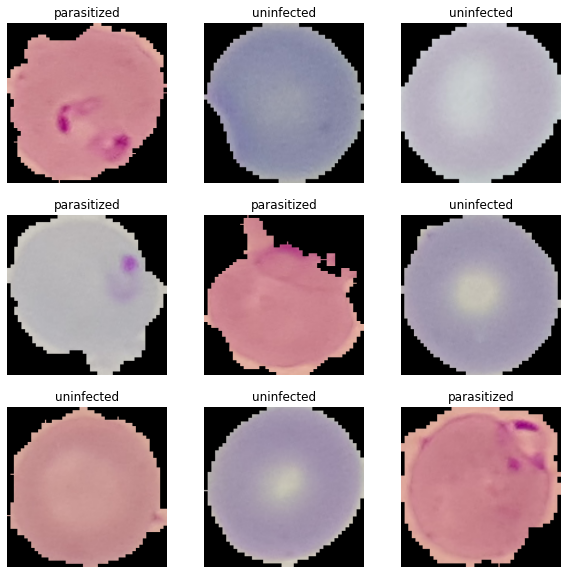

In [6]:
#show the first 9 images and labels from the training set:

class_names = train_dataset.class_names

plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
#here we split the validation set to test and validation set

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 139
Number of test batches: 34


In [8]:
#rescale the pixels
#using the preprocessing method included with the model mobilenetv2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)


In [9]:
#Preparing the pretrained model

IMG_SHAPE = IMG_SIZE + (3,)

#create the base model
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [10]:
#feature extractor
feature_extractor.trainable = False

#base model architecture
feature_extractor.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = feature_extractor(x, training=False)
x= global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
#compile the model

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281  

In [14]:
initial_epochs = 5
loss0, accuracy0 = model.evaluate(validation_dataset)

139/139 [==============================] - 97s 679ms/step - loss: 0.7521 - accuracy: 0.5441


In [15]:
#here we just evaluated the model on the validation set
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.75
initial accuracy: 0.54


In [16]:
#now let us fit the model on the train set and validate it

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/5
689/689 [==============================] - 560s 808ms/step - loss: 0.4337 - accuracy: 0.8023 - val_loss: 0.2741 - val_accuracy: 0.9048
Epoch 2/5
689/689 [==============================] - 558s 810ms/step - loss: 0.2807 - accuracy: 0.8933 - val_loss: 0.2226 - val_accuracy: 0.9195
Epoch 3/5
689/689 [==============================] - 558s 810ms/step - loss: 0.2460 - accuracy: 0.9089 - val_loss: 0.2034 - val_accuracy: 0.9241
Epoch 4/5
689/689 [==============================] - 558s 810ms/step - loss: 0.2274 - accuracy: 0.9173 - val_loss: 0.1913 - val_accuracy: 0.9286
Epoch 5/5
689/689 [==============================] - 564s 818ms/step - loss: 0.2161 - accuracy: 0.9220 - val_loss: 0.1849 - val_accuracy: 0.9322


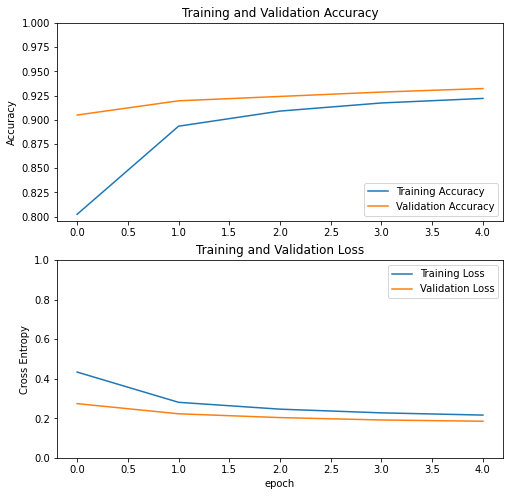

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Fine Tuning**

The above part we used feature extraction method to train few layers of the pretrained model and the weights of the pretrained model were not updated.

Now, we will be increasing the performance by fine-tunning the weights of the top layers of the pre-trained models alongside the training of the classifier. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: Fine tune small number of top layers than the whole model. The first few layers learn very simple and generic features that generalize to almost all types of images. As we move higher up, the features are increasingly more specific to the dataset on which the modle was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwriting the generic learning.

In [18]:
#Unfreeze the top layers
feature_extractor.trainable = True

#printing the number of layers in the feature extractor model
print("Number of layers: ", len(feature_extractor.layers))

#Fine tune from this layer
fine_tune_at = 100

#Freeze all the layers before the fine_tune_at layer
for layer in feature_extractor.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers:  154


In [19]:
#compile the model
#As the model is much larger better to use lower learning rate

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281  

In [20]:
fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 5/10
689/689 [==============================] - 797s 1s/step - loss: 0.1882 - accuracy: 0.9334 - val_loss: 0.1168 - val_accuracy: 0.9589
Epoch 6/10
689/689 [==============================] - 797s 1s/step - loss: 0.1239 - accuracy: 0.9568 - val_loss: 0.1059 - val_accuracy: 0.9632
Epoch 7/10
689/689 [==============================] - 787s 1s/step - loss: 0.1098 - accuracy: 0.9616 - val_loss: 0.1026 - val_accuracy: 0.9641
Epoch 8/10
689/689 [==============================] - 787s 1s/step - loss: 0.0973 - accuracy: 0.9652 - val_loss: 0.1040 - val_accuracy: 0.9638
Epoch 9/10
689/689 [==============================] - 785s 1s/step - loss: 0.0888 - accuracy: 0.9685 - val_loss: 0.1030 - val_accuracy: 0.9672
Epoch 10/10
689/689 [==============================] - 785s 1s/step - loss: 0.0825 - accuracy: 0.9708 - val_loss: 0.1191 - val_accuracy: 0.9623


In [21]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

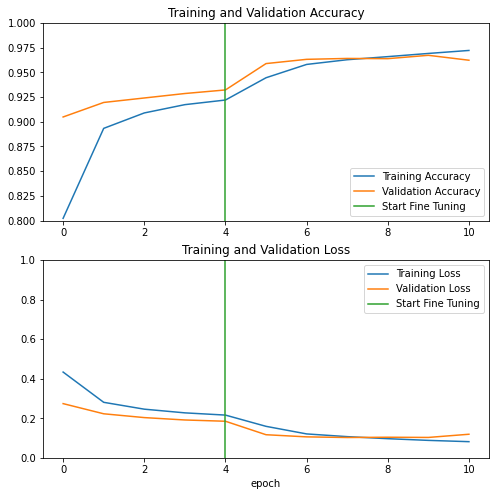

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
#Evaluation

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

34/34 [==============================] - 21s 594ms/step - loss: 0.1299 - accuracy: 0.9522
Test accuracy : 0.9522058963775635


Predictions:
 [0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1]
Labels:
 [0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1]


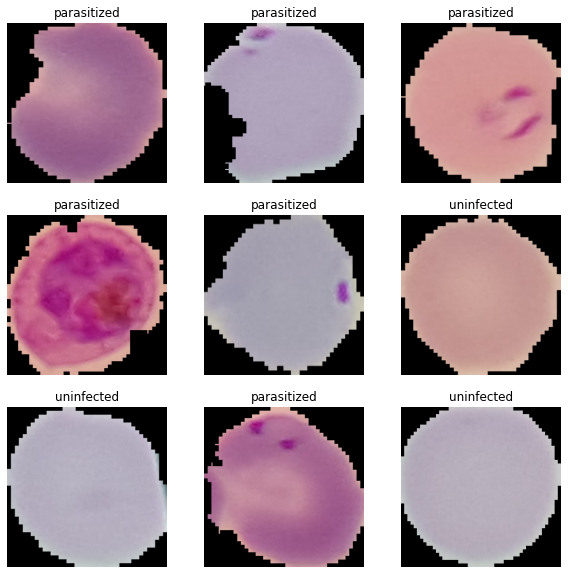

In [31]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")




1.  In the above example of classification of images of cells infected with malaria and the ones without we can conclude that fine tuning works best compared to feature extraction from the plots obtained. The accuracy increases when the model is fine tuned. But we have to be careful while choosing among the two for a smaller data set feature extraction works better as we have lesser data to retrain the model in case of fine tuning and vice versa for the larger dataset. We also need to take care that the training data set is similar to the pretrained dataset of the model in case of fine tuning.

2.  Training a model from scratch is better as we can improve the performance of the model drastically. The only disadvantage is the requirement of huge datasets, time, computational capabilities. Usually one can prove the performance on the problem statement by using transfer learning and then opt for training a model to improve the performance.

3.  As we saw a new model was utilized in the example above we need to take care of the input image shape, pixels. We would have to rescale the pixels based on the model. The above mentioned points also have to be kept in mind before choosing a model.





